In [3]:
!pip3 install matplotlib

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [89]:
# Load data
df = pd.read_csv('Churn_Modelling-2.csv')

# Convert specific columns to numeric
columns_to_convert = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'HasCrCard', 'Exited']
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Assuming 'Exited' is the target variable
X = df.drop(columns=['Exited'])  # Drop the target column from X
Y = df['Exited']  # Target variable

print(X.shape)
print(Y.shape)

(10000, 13)
(10000,)


In [90]:
# Removing the redundant and focusing on relevant features
X = X.drop(X.columns[:3], axis=1)
print('X after removing features:', X.shape)

# Label Encoding for Gender: 'Male' -> 1, 'Female' -> 0 
X['Gender'] = X['Gender'].map({'Male': 1, 'Female': 0}) 

# One-Hot Encoding for Geography, generating Geography_Germany and Geography_Spain 
X = pd.get_dummies(X, columns=['Geography'], drop_first=True) 

# Convert boolean columns (True/False) to integers (1/0) for one-hot encoded columns 
X['Geography_Germany'] = X['Geography_Germany'].astype(int) 
X['Geography_Spain'] = X['Geography_Spain'].astype(int) 

print(X.head())

X after removing features: (10000, 10)
   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  
0               1        101348.88                  0                0  
1               1        112542.58                  0                1  
2               0        113931.57                  0                0  
3               0         93826.63                  0                0  
4               1         79084.10                  0                1  


In [91]:
# Perform train-test split (25% test size)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8000, 11)
(8000,)
(2000, 11)
(2000,)


In [92]:
#Discretization of data
def discretize_data(X, num_bins):
    """
    Discretize continuous features in X into a given number of bins.
    """
    X_discretized = X.copy()
    for column in ['CreditScore', 'Age', 'Balance', 'EstimatedSalary','Tenure']:
        # Discretize by binning, replace values by bin indices
        X_discretized[column] = pd.cut(X[column], bins=num_bins, labels=False)
    return X_discretized

In [ ]:
# Train ID3 (Decision Tree) algorithm on the discretized data.
def train_id3(X_train, X_test, Y_train, Y_test):
    id3 = DecisionTreeClassifier(criterion='entropy')  # ID3 algorithm uses 'entropy'
    id3.fit(X_train, Y_train)
    y_pred_id3 = id3.predict(X_test)

    #calculate metrics
    accuracy_id3, f1_score_id3 = calculate_metrics(Y_test, y_pred_id3)
    return y_pred_id3, accuracy_id3, f1_score_id3

In [ ]:
class NaiveBayes:
    def __init__(self):
        self.class_probs = {}
        self.cond_probs = {}

    def fit(self, X, y):
        # Calculate class probabilities
        self.class_probs = {c: np.mean(y == c) for c in np.unique(y)}

        # Calculate conditional probabilities
        self.cond_probs = {}
        for c in np.unique(y):
            self.cond_probs[c] = {}
            X_c = X[y == c]
            for col in X.columns:
                self.cond_probs[c][col] = X_c[col].value_counts(normalize=True).to_dict()

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            probs = {}
            for c in self.class_probs:
                probs[c] = self.class_probs[c]  # P(C)
                for col in X.columns:
                    value = X.iloc[i][col]
                    # P(X|C)
                    probs[c] *= self.cond_probs[c].get(col, {}).get(value, 1e-6)  # small value for smoothing

            # Choose the class with the highest posterior probability
            predictions.append(max(probs, key=probs.get))
        return np.array(predictions)

In [ ]:
#Calcuation of F1_score and Accuracy_score
def calculate_metrics(Y_test, Y_pred):
    tp = np.sum((Y_test == 1) & (Y_pred == 1))
    tn = np.sum((Y_test == 0) & (Y_pred == 0))
    fp = np.sum((Y_test == 0) & (Y_pred == 1))
    fn = np.sum((Y_test == 1) & (Y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return accuracy, f1_score

In [ ]:
# Define bin sizes to evaluate
bin_sizes = [5, 10, 15, 20]
n_splits = 5  # Number of train-test splits

# Lists to store results for different bin sizes
accuracies_id3 = {bins: [] for bins in bin_sizes}  # Dictionary to hold accuracies for each bin
f1_scores_id3 = {bins: [] for bins in bin_sizes}   # Dictionary to hold F1 scores for each bin

# Lists to store accuracies for each bin size
accuracies_nb = {bins: [] for bins in bin_sizes}
f1_scores_nb = {bins: [] for bins in bin_sizes}

# Iterate over the number of splits
for _ in range(n_splits):
    # Create train-test split
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.33, random_state=None)
    
    # Iterate over each bin size
    for bins in bin_sizes:
        # Discretize the data
        X_train_discrete = discretize_data(X_train_split, num_bins=bins)
        X_test_discrete = discretize_data(X_test_split, num_bins=bins)

        # Train and evaluate the ID3 model
        y_pred_id3, accuracy_id3, f1_id3 = train_id3(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)
        # Store accuracy and F1 score for this bin for ID3
        accuracies_id3[bins].append(accuracy_id3)
        f1_scores_id3[bins].append(f1_id3)

        # Train Naive Bayes
        nb = NaiveBayes()
        nb.fit(X_train_discrete, Y_train_split)
        y_pred_nb = nb.predict(X_test_discrete)
        
        # Calculate accuracy and F1 score for this bin for Naive Bayes
        accuracy_nb = np.mean(y_pred_nb == Y_test_split)
        accuracies_nb[bins].append(accuracy_nb)
        #calculate metrics
        _, f1_score_nb = calculate_metrics(Y_test_split, y_pred_nb)
        f1_scores_nb[bins].append(f1_score_nb)

# Calculate max, min, and average accuracy for each bin size for ID3
for bins in bin_sizes:
    print('Bins: ', bins)
    print('Accuracies: ', [float(acc) for acc in accuracies_id3[bins]])
    print('Min Accuracy: ', np.min(accuracies_id3[bins]))
    print('Max Accuracy: ', np.max(accuracies_id3[bins]))
    print('Avg Accuracy: ', np.average(accuracies_id3[bins]))

# Calculate max, min, and average accuracy for each bin size for Naive Bayes
for bins in bin_sizes:
    print('Bins: ', bins)
    print('Accuracies: ', [float(acc) for acc in accuracies_nb[bins]])
    print('Min Accuracy: ', np.min(accuracies_nb[bins]))
    print('Max Accuracy: ', np.max(accuracies_nb[bins]))
    print('Avg Accuracy: ', np.average(accuracies_nb[bins]))

# Plot the accuracy scores
plt.figure(figsize=(12, 5))

for bins in bin_sizes:
    plt.plot([bins]*n_splits, accuracies_id3[bins], marker='o', label=f'Accuracy for Bins: {bins}', linestyle='-', linewidth=2)

plt.xlabel('Number of Bins')
plt.ylabel('Accuracy')
plt.title('ID3 Accuracy vs Number of Bins')
plt.xticks(bin_sizes)  # Ensure ticks are at the bin sizes
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.figure(figsize=(12, 5))
for bins in bin_sizes:
    plt.plot([bins]*n_splits, f1_scores_id3[bins], marker='o', label=f'F1 Score for Bins: {bins}', linestyle='-', linewidth=2)

plt.xlabel('Number of Bins')
plt.ylabel('F1 Score')
plt.title('ID3 F1 Score vs Number of Bins')
plt.xticks(bin_sizes)  # Ensure ticks are at the bin sizes
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


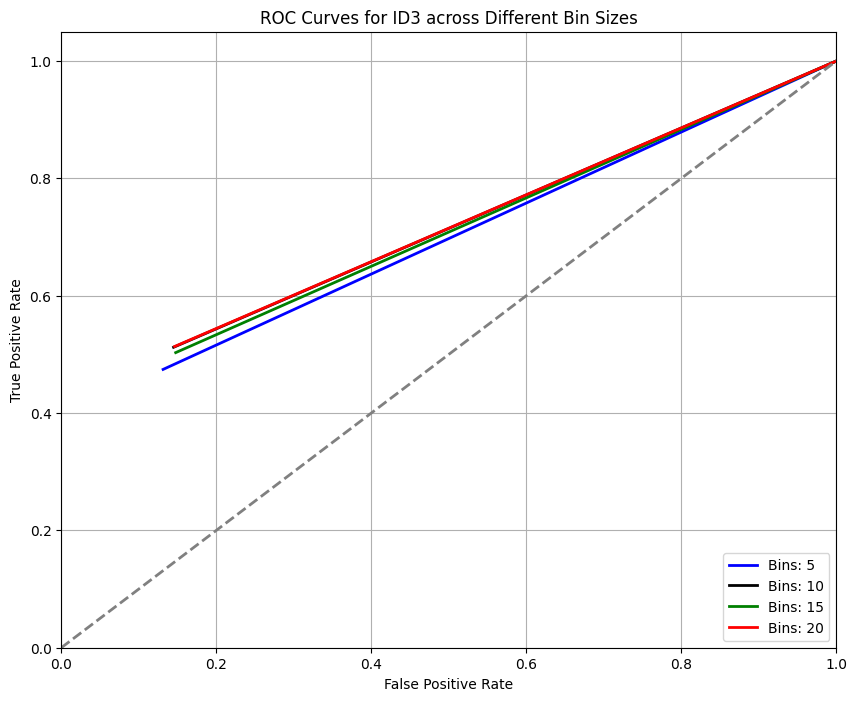

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate TPR and FPR
def calculate_tpr_fpr(y_true, y_scores, thresholds):
    tpr_list = []
    fpr_list = []

    # Loop through thresholds to calculate TPR and FPR
    for threshold in thresholds:
        # Classify based on the threshold
        y_pred = (y_scores >= threshold).astype(int)

        # True Positives, False Positives, True Negatives, False Negatives
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        # Calculate TPR and FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    return np.array(tpr_list), np.array(fpr_list)

# Define bin sizes to evaluate
bin_sizes = [5, 10, 15, 20]
n_splits = 5  # Number of train-test splits
roc_data = {bins: {'fpr': [], 'tpr': [], 'thresholds': []} for bins in bin_sizes}

# Iterate over the number of splits
for _ in range(n_splits):
    # Create train-test split
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.33, random_state=None)

    # Iterate over each bin size
    for bins in bin_sizes:
        # Discretize the data
        X_train_discrete = discretize_data(X_train_split, num_bins=bins)
        X_test_discrete = discretize_data(X_test_split, num_bins=bins)

        # Train the ID3 model and get the predicted probabilities
        y_pred_proba_id3,_,_ = train_id3(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)

        # Get unique thresholds from predicted probabilities
        thresholds = np.linspace(0, 1, 100)  # 100 thresholds from 0 to 1

        # Compute TPR and FPR
        tpr, fpr = calculate_tpr_fpr(Y_test_split, y_pred_proba_id3, thresholds)

        roc_data[bins]['fpr'].append(fpr)
        roc_data[bins]['tpr'].append(tpr)

# Plotting ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'black', 'green', 'red']

for i, bins in enumerate(bin_sizes):
    # Average the TPR and FPR over all splits for smoother ROC
    mean_fpr = np.mean([roc_data[bins]['fpr'][j] for j in range(n_splits)], axis=0)
    mean_tpr = np.mean([roc_data[bins]['tpr'][j] for j in range(n_splits)], axis=0)

    # Plot the ROC curve
    plt.plot(mean_fpr, mean_tpr, color=colors[i], lw=2, label=f'Bins: {bins}')

# Plotting the diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)

# Finalizing the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ID3 across Different Bin Sizes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
